In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command

state for the farm

In [2]:
# Additional imports for livestock RAG integration
import re
import pandas as pd
import os
import pymssql
from typing import List, Dict, Any, Optional
from google.cloud import firestore
from google.cloud.firestore_v1.vector import Vector
from google.cloud.firestore_v1.base_vector_query import DistanceMeasure


In [3]:
from typing import TypedDict, List, Optional, Dict, Any

class FarmState(TypedDict, total=False):
    """State for managing farm information and diagnostics"""
    farm_name: Optional[str]
    location: Optional[str]
    farm_size: Optional[str]  # e.g., "5 acres", "2 hectares"
    crops: Optional[List[str]]  # List of crops/plants being grown
    current_issues: Optional[List[str]]  # List of current problems or concerns
    history: Optional[List[str]]  # Conversation history
    diagnosis: Optional[str]  # Final diagnosis or advice
    soil_info: Optional[Dict[str, Any]]  # Soil type, pH, nutrients, etc.
    weather_conditions: Optional[Dict[str, Any]]  # Recent weather data
    management_practices: Optional[List[str]]  # Current farming practices
    recommendations: Optional[List[str]]  # Actionable recommendations

## Livestock RAG Configuration and Database Classes


## 🔧 Critical Fix: FarmState Missing Fields

**Root Cause of Infinite Loop:**
The `FarmState` TypedDict was missing `assessment_summary` and `advisory_type` fields!

When `assessment_node` returned `{"assessment_summary": "..."}`, LangGraph **ignored the update** because the field wasn't defined in the state schema. This caused:
- The routing function to always see `None` for `assessment_summary`
- Infinite loop back to `assessment_node`
- Recursion limit exceeded

**Solution:**  
Added the missing fields to `FarmState` definition below.


In [4]:
# FIX: Add missing fields to FarmState
# The assessment_summary and advisory_type fields were missing from the original FarmState definition
# This caused the infinite loop because state updates were being ignored!

from typing import TypedDict, Optional, List, Dict, Any

class FarmState(TypedDict, total=False):
    """State for managing farm information and diagnostics"""
    farm_name: Optional[str]
    location: Optional[str]
    farm_size: Optional[str]
    crops: Optional[List[str]]
    current_issues: Optional[List[str]]
    history: Optional[List[str]]
    diagnosis: Optional[str]
    soil_info: Optional[Dict[str, Any]]
    weather_conditions: Optional[Dict[str, Any]]
    management_practices: Optional[List[str]]
    recommendations: Optional[List[str]]
    # CRITICAL MISSING FIELDS - These are needed for the assessment -> routing flow!
    assessment_summary: Optional[str]  # Summary of assessment phase
    advisory_type: Optional[str]  # Type: 'livestock', 'crops', or 'mixed'

print("✓ FarmState updated with assessment_summary and advisory_type fields!")


✓ FarmState updated with assessment_summary and advisory_type fields!


In [5]:
# Livestock Database and RAG Configuration
DB_CONFIG = {
    "host": os.getenv("DB_HOST", "").strip(),
    "port": int(os.getenv("DB_PORT", "1433").strip()),
    "user": os.getenv("DB_USER", "").strip(),
    "password": os.getenv("DB_PASSWORD", ""),
    "database": os.getenv("DB_NAME", "").strip(),
}

# Allowed tables for security
ALLOWED_TABLES = [
    "Speciesavailable",
    "Speciesbreedlookuptable",
    "Speciescategory",
    "Speciescolorlookuptable",
    "Speciespatternlookuptable",
    "Speciesregistrationtypelookuptable",
]

# GCP Configuration
GCP_PROJECT = os.getenv("GOOGLE_CLOUD_PROJECT", "").strip()
GCP_LOCATION = os.getenv("GOOGLE_CLOUD_LOCATION", "us-central1").strip()
GCP_CREDENTIALS = os.getenv("GOOGLE_APPLICATION_CREDENTIALS", "").strip()

# RAG Configuration
EMBEDDING_MODEL = "text-embedding-004"
EMBEDDING_DIMENSIONS = 768
TOP_K_RESULTS = 10

# Firestore Configuration
FIRESTORE_DATABASE = os.getenv("FIRESTORE_DATABASE", "charlie").strip()
FIRESTORE_COLLECTION = "livestock_knowledge"

print(f"[Config] Livestock RAG enabled (Project: {GCP_PROJECT}, Firestore DB: {FIRESTORE_DATABASE})")


[Config] Livestock RAG enabled (Project: animated-flare-421518, Firestore DB: charlie)


In [6]:
# Database class for livestock data
class Database:
    """Manages database connections and queries for livestock data."""

    def __init__(self):
        self._connection = None
        self._allowed_tables = [t.lower() for t in ALLOWED_TABLES]

    @property
    def connection(self):
        """Lazy connection to database."""
        if self._connection is None:
            try:
                self._connection = pymssql.connect(
                    server=DB_CONFIG["host"],
                    port=DB_CONFIG["port"],
                    user=DB_CONFIG["user"],
                    password=DB_CONFIG["password"],
                    database=DB_CONFIG["database"],
                    as_dict=True
                )
                print(f"[DB] Connected to {DB_CONFIG['database']}")
            except Exception as e:
                print(f"[DB] Connection failed: {e}")
                # Don't raise - allow graceful degradation
        return self._connection

    def _validate_query(self, query: str) -> None:
        """Validate query only accesses allowed tables."""
        query_lower = query.lower()
        tables = re.findall(r'from\s+\[?(\w+)\]?', query_lower)
        tables += re.findall(r'join\s+\[?(\w+)\]?', query_lower)

        for table in tables:
            if table not in self._allowed_tables:
                raise PermissionError(f"Access denied to table: {table}")

    def execute(self, query: str) -> pd.DataFrame:
        """Execute a SELECT query and return results as DataFrame."""
        if not self.connection:
            return pd.DataFrame()
        
        self._validate_query(query)
        cursor = self.connection.cursor()
        cursor.execute(query)
        results = cursor.fetchall()
        return pd.DataFrame(results) if results else pd.DataFrame()

    def get_all_breeds(self) -> List[Dict[str, Any]]:
        """Get all breeds with species info."""
        df = self.execute("""
            SELECT TOP 2000 b.BreedLookupID, b.Breed, b.Breeddescription,
                   b.MeatBreed, b.MilkBreed, b.WoolBreed, b.EggBreed, b.Working,
                   s.Species, s.SpeciesID
            FROM Speciesbreedlookuptable b
            JOIN Speciesavailable s ON b.SpeciesID = s.SpeciesID
            WHERE b.breedavailable = 1
        """)
        return df.to_dict('records') if not df.empty else []

    def get_all_species(self) -> List[Dict[str, Any]]:
        """Get all species with their details."""
        df = self.execute("""
            SELECT SpeciesID, Species, MaleTerm, FemaleTerm, BabyTerm,
                   SingularTerm, PluralTerm, GestationPeriod
            FROM Speciesavailable
            WHERE SpeciesAvailable = 1
        """)
        return df.to_dict('records') if not df.empty else []

    def get_colors_for_species(self, species_id: int) -> List[str]:
        """Get available colors for a species."""
        df = self.execute(f"""
            SELECT DISTINCT SpeciesColor
            FROM Speciescolorlookuptable
            WHERE SpeciesID = {species_id}
        """)
        return df['SpeciesColor'].tolist() if not df.empty else []

    def get_patterns_for_species(self, species_id: int) -> List[str]:
        """Get available patterns for a species."""
        df = self.execute(f"""
            SELECT DISTINCT SpeciesColor as Pattern
            FROM Speciespatternlookuptable
            WHERE SpeciesID = {species_id}
        """)
        return df['Pattern'].tolist() if not df.empty else []

    def get_categories_for_species(self, species_id: int) -> List[str]:
        """Get categories for a species."""
        df = self.execute(f"""
            SELECT SpeciesCategory
            FROM Speciescategory
            WHERE SpeciesID = {species_id}
            ORDER BY SpeciesCategoryOrder
        """)
        return df['SpeciesCategory'].tolist() if not df.empty else []

# Create database instance
db = Database()
print("[DB] Database class initialized")


[DB] Database class initialized


In [7]:
# Initialize embedding model
from langchain_google_vertexai import VertexAIEmbeddings

embeddings = VertexAIEmbeddings(
    model_name=EMBEDDING_MODEL,
    project=GCP_PROJECT,
    location=GCP_LOCATION
)
print(f"[RAG] Using Vertex AI Embeddings ({EMBEDDING_MODEL})")


C:\Users\bring\AppData\Local\Temp\ipykernel_22268\3471930439.py:4: DeprecationWarning: Use [`GoogleGenerativeAIEmbeddings`][langchain_google_genai.GoogleGenerativeAIEmbeddings] instead.
  embeddings = VertexAIEmbeddings(
C:\Users\bring\AppData\Local\Temp\ipykernel_22268\3471930439.py:4: LangChainDeprecationWarning: The class `VertexAIEmbeddings` was deprecated in LangChain 3.2.0 and will be removed in 4.0.0. An updated version of the class exists in the `langchain-google-genai package and should be used instead. To use it run `pip install -U `langchain-google-genai` and import as `from `langchain_google_genai import GoogleGenerativeAIEmbeddings``.
  embeddings = VertexAIEmbeddings(


[RAG] Using Vertex AI Embeddings (text-embedding-004)


In [8]:
# RAG System class
class RAGSystem:
    """RAG system using Firestore Vector Search for livestock knowledge."""

    def __init__(self):
        self._db = None
        self._initialized = False

    @property
    def firestore_db(self):
        """Lazy initialization of Firestore client."""
        if self._db is None:
            credentials = None
            if GCP_CREDENTIALS:
                try:
                    from google.oauth2 import service_account
                    credentials = service_account.Credentials.from_service_account_file(
                        GCP_CREDENTIALS,
                        scopes=["https://www.googleapis.com/auth/cloud-platform"]
                    )
                    print(f"[RAG] Loaded credentials from {GCP_CREDENTIALS}")
                except Exception as e:
                    print(f"[RAG] Warning: Could not load credentials: {e}")
            
            if credentials:
                self._db = firestore.Client(
                    project=GCP_PROJECT,
                    database=FIRESTORE_DATABASE,
                    credentials=credentials
                )
            else:
                self._db = firestore.Client(
                    project=GCP_PROJECT,
                    database=FIRESTORE_DATABASE
                )
            print(f"[RAG] Connected to Firestore (Database: {FIRESTORE_DATABASE})")
        return self._db

    @property
    def collection(self):
        """Get the Firestore collection."""
        return self.firestore_db.collection(FIRESTORE_COLLECTION)

    def _get_embedding(self, text: str) -> List[float]:
        """Generate embedding for text."""
        return embeddings.embed_query(text)

    def _check_if_indexed(self) -> bool:
        """Check if data is already indexed in Firestore."""
        docs = self.collection.limit(1).get()
        return len(list(docs)) > 0

    def initialize(self):
        """Initialize the RAG system - check if index exists."""
        if not self._initialized:
            if self._check_if_indexed():
                try:
                    count_query = self.collection.count()
                    result = count_query.get()
                    count = result[0][0].value
                    print(f"[RAG] Using existing Firestore index ({count} documents)")
                except:
                    print("[RAG] Using existing Firestore index")
                self._initialized = True
            else:
                print("[RAG] Warning: No livestock data indexed in Firestore")
                print("[RAG] Run livestock.ipynb to index data first")
        return self._initialized

    def search(self, query: str, n_results: int = TOP_K_RESULTS) -> List[Dict[str, Any]]:
        """Search for relevant livestock documents using vector similarity."""
        if not self._initialized:
            self.initialize()

        # Generate query embedding
        query_embedding = self._get_embedding(query)

        # Perform vector search
        vector_query = self.collection.find_nearest(
            vector_field="embedding",
            query_vector=Vector(query_embedding),
            distance_measure=DistanceMeasure.COSINE,
            limit=n_results
        )

        results = vector_query.get()

        # Format results
        formatted = []
        for doc in results:
            data = doc.to_dict()
            formatted.append({
                "content": data.get("content", ""),
                "metadata": data.get("metadata", {}),
                "type": data.get("type", "unknown"),
            })

        return formatted

    def get_context_for_query(self, query: str) -> str:
        """Get formatted context string for LLM."""
        results = self.search(query)

        if not results:
            return ""

        context_parts = ["Relevant livestock information from database:\n"]
        for i, result in enumerate(results, 1):
            context_parts.append(f"{i}. {result['content']}")

        return "\n".join(context_parts)

# Create RAG instance
rag = RAGSystem()
print("[RAG] RAG System class initialized")


[RAG] RAG System class initialized


LLM intialization and pydantic models

In [9]:
import os
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv()

# Use the full initialize_llm function from main.py
def initialize_llm():
    """
    Initialize ChatGoogleGenerativeAI with either:
    1. Vertex AI (Google Cloud) - if project/credentials are available
    2. Gemini Developer API - if API key is available
    """
    # Check for Vertex AI configuration
    project = os.getenv("GOOGLE_CLOUD_PROJECT")
    location = os.getenv("GOOGLE_CLOUD_LOCATION", "us-central1")
    use_vertexai = os.getenv("GOOGLE_GENAI_USE_VERTEXAI", "").lower() == "true"
    service_account_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
    
    # Check if we should use Vertex AI
    if use_vertexai or project:
        # Vertex AI mode
        vertex_model = os.getenv("VERTEX_AI_MODEL", "gemini-2.5-flash-lite")
        llm_kwargs = {
            "model": vertex_model,
            "temperature": 0,
        }
        
        # Add project if available
        if project:
            llm_kwargs["project"] = project
        
        # Add location if specified
        if location:
            llm_kwargs["location"] = location
        
        # Add credentials if service account file is provided
        if service_account_path:
            try:
                from google.oauth2 import service_account
                credentials = service_account.Credentials.from_service_account_file(
                    service_account_path,
                    scopes=["https://www.googleapis.com/auth/cloud-platform"],
                )
                llm_kwargs["credentials"] = credentials
            except ImportError:
                raise ImportError(
                    "google-auth library is required for service account authentication. "
                    "Install it with: pip install google-auth"
                )
            except Exception as e:
                raise ValueError(f"Failed to load service account credentials from {service_account_path}: {e}")
        
        # Explicitly set vertexai=True if project is set
        if project:
            llm_kwargs["vertexai"] = True
        
        print(f"Initializing with Vertex AI (project: {project}, location: {location})")
        return ChatGoogleGenerativeAI(**llm_kwargs)
    
    # Fall back to Gemini Developer API with API key
    api_key = os.getenv("GOOGLE_API_KEY") or os.getenv("GEMINI_API_KEY")
    if not api_key:
        raise ValueError(
            "No authentication method found. Please set one of:\n"
            "  - GOOGLE_API_KEY or GEMINI_API_KEY for Gemini Developer API\n"
            "  - GOOGLE_CLOUD_PROJECT for Vertex AI (with ADC or GOOGLE_APPLICATION_CREDENTIALS)"
        )
    
    print("Initializing with Gemini Developer API (API key)")
    # Try a model that works with API keys (gemini-1.5-flash or gemini-1.5-pro)
    dev_model = os.getenv("GEMINI_MODEL", "gemini-1.5-flash")
    return ChatGoogleGenerativeAI(
        model=dev_model,
        temperature=0,
    )

# Initialize LLM
llm = initialize_llm()

# Pydantic model for assessment decisions
class AssessmentDecision(BaseModel):
    is_complete: bool = Field(description="True if enough farm information has been collected")
    question: str = Field(description="Question to ask the user. Required if is_complete=False.")
    options: Optional[List[str]] = Field(default=None, description="3-4 specific options if is_complete=False")
    assessment_summary: Optional[str] = Field(default=None, description="Summary of collected farm information. Required if is_complete=True.")

Initializing with Vertex AI (project: animated-flare-421518, location: us-central1)


adding nodes

In [10]:
# Pydantic model for query classification (hybrid routing)
class QueryClassification(BaseModel):
    category: str = Field(
        description="Classification: 'livestock', 'crops', or 'mixed'"
    )
    confidence: str = Field(
        description="Confidence: 'high' or 'low'"
    )
    reasoning: str = Field(
        description="Brief explanation of classification"
    )

print("[Models] Query classification model defined")


[Models] Query classification model defined


In [11]:
def assessment_node(state: FarmState):
    """
    Node to assess and collect farm information through Q&A.
    
    Flow:
    1. LLM generates question based on current state
    2. interrupt() pauses execution and waits for user input
    3. When resumed, node runs from beginning with updated state (history includes Q&A)
    4. LLM is invoked again with new context - this is intentional and correct
    5. Process continues until completion criteria met
    """
    structured_llm = llm.with_structured_output(AssessmentDecision)
    
    # Get current state values
    # Note: When resuming after interrupt(), state will include the previous Q&A in history
    history = state.get("history") or []
    farm_name = state.get("farm_name")
    location = state.get("location")
    farm_size = state.get("farm_size")
    crops = state.get("crops") or []
    current_issues = state.get("current_issues") or []
    
    # CRITICAL: If assessment_summary already exists, we've already completed
    # This prevents infinite loops if we somehow get called again after completion
    if state.get("assessment_summary"):
        print(f"[Assessment] ✓ Already completed - assessment_summary exists. Routing should handle this.")
        print(f"[Assessment] Summary: {state.get('assessment_summary')[:100]}...")
        return {}  # No update needed, routing function will see assessment_summary and route away
    
    # Format existing information
    existing_info = []
    if farm_name:
        existing_info.append(f"Farm Name: {farm_name}")
    if location:
        existing_info.append(f"Location: {location}")
    if farm_size:
        existing_info.append(f"Farm Size: {farm_size}")
    if crops:
        existing_info.append(f"Crops: {', '.join(crops)}")
    if current_issues:
        existing_info.append(f"Issues: {', '.join(current_issues)}")
    
    info_text = "\n".join(existing_info) if existing_info else "No information collected yet."
    history_text = "\n".join(history) if history else "No previous conversation."
    
    # Extract all questions already asked
    questions_asked = [h.replace("AI: ", "") for h in history if h.startswith("AI:")]
    
    question_count = len(questions_asked)
    MAX_QUESTIONS = 8
    
    # Check if this is the first interaction (no AI questions yet)
    is_first_interaction = question_count == 0
    
    # Check if we have minimum required info (NEW: Issue-first approach)
    # We need: 1) user's issue, 2) what they're growing/raising, 3) location (optional)
    has_issue = bool(current_issues)
    has_crops_or_livestock = bool(crops)
    has_location = bool(location)
    
    # Basic info = issue + crops/livestock (name and size are optional)
    has_basic_info = has_issue and has_crops_or_livestock
    
    # Completion logic prioritizing user's concern:
    # 1. If we have issue + crops + location after 2-3 questions, complete
    # 2. If we have issue + crops after 3-4 questions, complete
    # 3. If max questions reached, complete
    should_complete = False
    completion_reason = ""
    
    print(f"\n[DEBUG] Completion check (issue-first approach):")
    print(f"  - question_count: {question_count} (max: {MAX_QUESTIONS})")
    print(f"  - has_issue: {has_issue} ({', '.join(current_issues) if current_issues else 'None'})")
    print(f"  - has_crops/livestock: {has_crops_or_livestock} ({', '.join(crops) if crops else 'None'})")
    print(f"  - has_location: {has_location} ({location if location else 'None'})")
    
    if question_count >= MAX_QUESTIONS:
        should_complete = True
        completion_reason = f"Maximum questions ({MAX_QUESTIONS}) reached"
        print(f"[DEBUG] Should complete: YES - {completion_reason}")
    elif has_issue and has_crops_or_livestock and has_location and question_count >= 2:
        should_complete = True
        completion_reason = f"Have core info (issue, crops/livestock, location) after {question_count} questions"
        print(f"[DEBUG] Should complete: YES - {completion_reason}")
    elif has_issue and has_crops_or_livestock and question_count >= 3:
        should_complete = True
        completion_reason = f"Have essential info (issue, crops/livestock) after {question_count} questions"
        print(f"[DEBUG] Should complete: YES - {completion_reason}")
    else:
        print(f"[DEBUG] Should complete: NO - continuing with questions")
    
    if should_complete:
        # Force completion - create assessment summary WITHOUT calling LLM again
        # (avoids complexity and potential loops from LLM structured output)
        print(f"\n[Assessment] ✓ Completing assessment: {completion_reason}")
        
        # Build comprehensive assessment summary from collected information
        summary_parts = []
        summary_parts.append(f"Farmer seeks assistance with: {', '.join(current_issues) if current_issues else 'general farm advice'}")
        if crops:
            summary_parts.append(f"Growing/Raising: {', '.join(crops)}")
        if location:
            summary_parts.append(f"Location: {location}")
        if farm_size:
            summary_parts.append(f"Farm size: {farm_size}")
        if farm_name:
            summary_parts.append(f"Farm name: {farm_name}")
        
        assessment_summary = " | ".join(summary_parts)
        
        print(f"[Assessment] Summary: {assessment_summary}")
        
        # Return state update with non-empty assessment_summary
        # This will trigger routing to routing_node
        return {"assessment_summary": assessment_summary}
    
    # Build list of questions already asked for the prompt
    questions_list = "\n".join([f"- {q}" for q in questions_asked]) if questions_asked else "None yet."
    
    # FIRST INTERACTION: Ask open-ended question to understand user's main concern
    if is_first_interaction:
        prompt = """You are a friendly farm advisor assistant. This is your first interaction with the farmer.

Task: Ask ONE open-ended question to understand what brings them here today.

Your question should:
1. Be warm and welcoming
2. Ask about their main concern, issue, or question
3. Encourage them to share details about their farm and what they need help with
4. NOT ask for specific details like name, location, size yet

Example questions:
- "Welcome! What brings you here today? Tell me about your farm and any challenges you're facing."
- "Hello! How can I help you with your farm today? What issues or questions do you have?"
- "Hi there! What would you like assistance with regarding your farm?"

Provide 3-4 options for common farm concerns as suggestions (but they can type freely):
- Examples: "Crop disease/pest issues", "Livestock health concerns", "Improving yields", "Tell me about something else"

Set is_complete=False and ask your welcoming question."""
    else:
        # FOLLOW-UP QUESTIONS: Now we can ask specific questions based on their initial response
        prompt = f"""Farm Information Collected So Far:
{info_text}

Conversation History:
{history_text}

Questions Already Asked:
{questions_list}

Task: Based on the user's initial concern, collect RELEVANT follow-up information.

CRITICAL RULES:
1. DO NOT repeat any question that has already been asked (see list above)
2. Prioritize questions that are RELEVANT to their specific issue/concern
3. Ask one NEW question at a time that hasn't been asked before
4. Provide 3-4 specific, descriptive options for each question
5. DO NOT use generic Yes/No options

Essential information to gather (if relevant to their concern):
- Location/region {'✓' if location else '✗'} (important for climate-specific advice)
- Crops/Livestock type {'✓' if crops else '✗'} (what are they growing/raising?)
- Farm size {'✓' if farm_size else '✗'} (optional, only if relevant to their issue)
- Farm name {'✓' if farm_name else '✗'} (optional, least important)

The user's main concern: {', '.join(current_issues) if current_issues else 'Not yet specified'}

CURRENT STATUS:
- Main issue/concern: {'✓' if current_issues else '✗'}
- Crops/Livestock: {'✓' if crops else '✗'}
- Location: {'✓' if location else '✗'}
- Farm size: {'✓' if farm_size else '✗'}
- Farm name: {'✓' if farm_name else '✗'}

Set is_complete=True when you have:
✓ User's main issue/concern
✓ What they're growing/raising (crops or livestock)
✓ Location (if needed for advice)
✓ Enough context to provide meaningful advisory

Questions asked: {question_count} (max: {MAX_QUESTIONS})

IMPORTANT: Prioritize understanding their PROBLEM over collecting metadata like farm name."""
    
    res = structured_llm.invoke(prompt)
    
    # Check if this question was already asked (duplicate detection)
    if res.question:
        question_lower = res.question.lower()
        # Check if similar question was already asked
        for prev_q in questions_asked:
            prev_q_lower = prev_q.lower()
            # Simple similarity check - if key words match, it's likely a duplicate
            key_words = ["severity", "impact", "observing", "describes"]
            if any(word in question_lower and word in prev_q_lower for word in key_words):
                # Likely duplicate - force completion
                print(f"⚠️ Detected duplicate question about '{question_lower[:50]}...' - completing assessment")
                prompt = f"""Farm Information Collected:
{info_text}

Conversation History:
{history_text}

You were about to repeat a question. You have enough information. Provide assessment summary. Set is_complete=True."""
                res = structured_llm.invoke(prompt)
                if not res.assessment_summary:
                    res.assessment_summary = "Assessment completed based on collected information."
                # Return state update - routing function will detect assessment_summary
                return {"assessment_summary": res.assessment_summary}
    
    if not res.is_complete:
        # Validate and enhance options
        options = res.options
        if not options or len(options) < 3:
            question_lower = res.question.lower()
            if "location" in question_lower or "where" in question_lower:
                options = ["North region", "South region", "Central region", "Other location"]
            elif "size" in question_lower or "acre" in question_lower:
                options = ["Small (1-5 acres)", "Medium (5-20 acres)", "Large (20-50 acres)", "Very large (50+ acres)"]
            elif "crop" in question_lower:
                options = ["Corn/Maize", "Wheat", "Rice", "Vegetables", "Fruits", "Other"]
            else:
                options = ["Option 1", "Option 2", "Option 3", "Other/Not sure"]
        
        ui_schema = {
            "type": "quiz",
            "question": res.question,
            "options": options
        }
        
        user_response = interrupt(ui_schema)
        
        # Update state based on question type
        # Note: When graph resumes after interrupt(), the node runs from the beginning
        # but with updated state, so history will include the previous Q&A
        updates = {"history": history + [f"AI: {res.question}", f"User: {user_response}"]}
        
        # Try to extract structured data from responses
        # Important: Copy lists to avoid overwriting state (FarmState uses Optional[List], not reducers)
        question_lower = res.question.lower()
        
        # FIRST RESPONSE: User's initial open-ended response - extract multiple things
        if is_first_interaction:
            # The first response likely contains their main issue AND what they're growing
            # Store the whole response as their issue/concern
            updated_issues = list(current_issues) if current_issues else []
            if user_response not in updated_issues:
                updated_issues.append(user_response)
            updates["current_issues"] = updated_issues
            print(f"[Assessment] First interaction - captured user's main concern")
        
        # FOLLOW-UP RESPONSES: Extract specific data based on question type
        elif "name" in question_lower and "farm" in question_lower:
            updates["farm_name"] = user_response
        elif "location" in question_lower or "where" in question_lower or "region" in question_lower:
            updates["location"] = user_response
        elif "size" in question_lower or "acre" in question_lower or "hectare" in question_lower:
            updates["farm_size"] = user_response
        elif "crop" in question_lower or "growing" in question_lower or "plant" in question_lower:
            # Create a new list copy to avoid overwriting the state list
            updated_crops = list(crops) if crops else []
            if user_response not in updated_crops:
                updated_crops.append(user_response)
            updates["crops"] = updated_crops
        elif "livestock" in question_lower or "animal" in question_lower or "raising" in question_lower:
            # Livestock goes into crops field (we use it for both)
            updated_crops = list(crops) if crops else []
            if user_response not in updated_crops:
                updated_crops.append(user_response)
            updates["crops"] = updated_crops
        elif "issue" in question_lower or "problem" in question_lower or "concern" in question_lower:
            # Create a new list copy to avoid overwriting the state list
            updated_issues = list(current_issues) if current_issues else []
            if user_response not in updated_issues:
                updated_issues.append(user_response)
            updates["current_issues"] = updated_issues
        
        # Return state update - routing function will route back to assessment_node
        print(f"\n[DEBUG] Not complete yet, will loop back to assessment_node")
        print(f"[DEBUG] Updates: {list(updates.keys())}")
        return updates
    
    # Assessment complete
    assessment = res.assessment_summary
    if not assessment:
        assessment = "Farm assessment completed. Ready for advisory recommendations."
    
    print(f"\n[DEBUG] Assessment complete! Summary: {assessment[:50]}...")
    print(f"[DEBUG] Returning state update with assessment_summary (routing function will detect it)")
    
    # Return state update - routing function will check for assessment_summary and route to advisory
    # The state update is applied BEFORE the routing function is called
    return {"assessment_summary": assessment}


# Hybrid routing node - checks keywords first, then LLM if uncertain
def routing_node(state: FarmState) -> Dict[str, str]:
    """
    Hybrid routing: keyword matching first, LLM fallback for uncertain cases.
    Returns the advisory category for conditional routing.
    """
    crops = state.get("crops", [])
    issues = state.get("current_issues", [])
    assessment = state.get("assessment_summary", "")
    
    # Combine all context
    query_text = f"{' '.join(crops)} {' '.join(issues)} {assessment}".lower()
    
    # Define clear keywords
    livestock_keywords = [
        "cattle", "cow", "bull", "calf", "beef", "dairy",
        "sheep", "lamb", "ewe", "ram",
        "goat", "kid", "doe", "buck",
        "pig", "hog", "swine", "piglet", "pork",
        "chicken", "hen", "rooster", "chick", "poultry",
        "duck", "duckling", "goose", "gosling",
        "turkey", "horse", "mare", "stallion", "foal",
        "rabbit", "bunny", "livestock", "animal", "breed"
    ]
    
    crop_keywords = [
        "corn", "maize", "wheat", "rice", "barley", "oats",
        "soybean", "soy", "cotton", "tobacco",
        "tomato", "potato", "carrot", "onion", "lettuce",
        "cabbage", "broccoli", "pepper", "cucumber",
        "apple", "orange", "grape", "strawberry", "banana",
        "melon", "watermelon", "pumpkin", "squash",
        "bean", "pea", "lentil", "grain", "vegetable", "fruit"
    ]
    
    # Count matches
    livestock_matches = sum(1 for k in livestock_keywords if k in query_text)
    crop_matches = sum(1 for k in crop_keywords if k in query_text)
    
    print(f"[Routing] Keyword matches - Livestock: {livestock_matches}, Crops: {crop_matches}")
    
    # Clear livestock case (high confidence)
    if livestock_matches > 0 and crop_matches == 0:
        print(f"[Routing] → livestock_advisory_node (keyword match)")
        return {"advisory_type": "livestock"}
    
    # Clear crop case (high confidence)
    if crop_matches > 0 and livestock_matches == 0:
        print(f"[Routing] → crop_advisory_node (keyword match)")
        return {"advisory_type": "crops"}
    
    # Mixed case (both present)
    if livestock_matches > 0 and crop_matches > 0:
        print(f"[Routing] → mixed_advisory_node (both keywords found)")
        return {"advisory_type": "mixed"}
    
    # Uncertain case - fall back to LLM
    print(f"[Routing] Uncertain - using LLM classification...")
    
    classifier = llm.with_structured_output(QueryClassification)
    
    prompt = f"""Classify this farm query as 'livestock', 'crops', or 'mixed'.

Farm Information:
- Crops/Animals: {', '.join(crops) if crops else 'Not specified'}
- Issues: {', '.join(issues) if issues else 'None'}
- Summary: {assessment[:200] if assessment else 'None'}

Respond with category, confidence (high/low), and brief reasoning."""
    
    try:
        result = classifier.invoke(prompt)
        print(f"[Routing] LLM classified as: {result.category} (confidence: {result.confidence})")
        print(f"[Routing] Reasoning: {result.reasoning}")
        
        if "livestock" in result.category.lower():
            return {"advisory_type": "livestock"}
        elif "mixed" in result.category.lower():
            return {"advisory_type": "mixed"}
        else:
            return {"advisory_type": "crops"}
    except Exception as e:
        print(f"[Routing] LLM classification failed: {e}")
        # Default fallback
        return {"advisory_type": "crops"}


def livestock_advisory_node(state: FarmState):
    """Specialized node for livestock advisory with RAG"""
    print("\n[Livestock Advisory] Processing livestock-specific recommendations...")
    structured_llm = llm
    
    # Gather all farm information
    farm_name = state.get("farm_name", "Unknown")
    location = state.get("location", "Unknown")
    farm_size = state.get("farm_size", "Unknown")
    crops = state.get("crops") or []
    current_issues = state.get("current_issues") or []
    assessment_summary = state.get("assessment_summary", "")
    soil_info = state.get("soil_info", {})
    management_practices = state.get("management_practices", [])
    
    # Retrieve livestock RAG context
    livestock_context = ""
    query_text = f"{', '.join(crops)} {', '.join(current_issues)} {assessment_summary}"
    
    print("[Livestock Advisory] Retrieving breed information from RAG...")
    try:
        rag.initialize()
        livestock_context = rag.get_context_for_query(query_text)
        if livestock_context:
            print(f"[Livestock Advisory] ✓ Retrieved livestock knowledge from database")
    except Exception as e:
        print(f"[Livestock Advisory] ⚠ Could not retrieve livestock context: {e}")
    
    # Build livestock-specific prompt
    prompt_parts = [f"""🐄 LIVESTOCK FARM ADVISORY

Farm Information:
- Farm Name: {farm_name}
- Location: {location}
- Farm Size: {farm_size}
- Livestock: {', '.join(crops) if crops else 'Not specified'}
- Current Issues: {', '.join(current_issues) if current_issues else 'None specified'}
- Assessment Summary: {assessment_summary}
- Management Practices: {', '.join(management_practices) if management_practices else 'Not specified'}
"""]
    
    if livestock_context:
        prompt_parts.append(f"\n{livestock_context}\n")
    
    prompt_parts.append("""
Task: Provide comprehensive LIVESTOCK advisory recommendations.

You are a livestock management expert. Based on the information above, provide:
1. **Diagnosis** of current livestock health/management issues
2. **Breed Recommendations** - suggest optimal breeds based on:
   - Farm size and location
   - Purpose (meat, dairy, wool, eggs, etc.)
   - Management capabilities
3. **Health & Nutrition** - feeding schedules, supplements, health monitoring
4. **Housing & Facilities** - shelter requirements, space per animal
5. **Best Practices** - breeding, weaning, seasonal care
6. **Actionable Steps** - immediate actions the farmer can take

Format your response with clear headings and bullet points.""")
    
    prompt = "\n".join(prompt_parts)
    
    advice = structured_llm.invoke(prompt)
    
    # Extract text if it's a message object
    if hasattr(advice, 'content'):
        advice_text = advice.content
    else:
        advice_text = str(advice)
    
    recommendations = [rec.strip() for rec in advice_text.split('\n') if rec.strip() and rec.strip().startswith(('-', '•', '1.', '2.', '3.'))]
    
    return {
        "diagnosis": advice_text,
        "recommendations": recommendations if recommendations else [advice_text]
    }


def crop_advisory_node(state: FarmState):
    """Specialized node for crop advisory"""
    print("\n[Crop Advisory] Processing crop-specific recommendations...")
    structured_llm = llm
    
    # Gather all farm information
    farm_name = state.get("farm_name", "Unknown")
    location = state.get("location", "Unknown")
    farm_size = state.get("farm_size", "Unknown")
    crops = state.get("crops") or []
    current_issues = state.get("current_issues") or []
    assessment_summary = state.get("assessment_summary", "")
    soil_info = state.get("soil_info", {})
    management_practices = state.get("management_practices", [])
    
    # Build crop-specific prompt
    prompt = f"""🌾 CROP FARM ADVISORY

Farm Information:
- Farm Name: {farm_name}
- Location: {location}
- Farm Size: {farm_size}
- Crops: {', '.join(crops) if crops else 'Not specified'}
- Current Issues: {', '.join(current_issues) if current_issues else 'None specified'}
- Assessment Summary: {assessment_summary}
- Soil Information: {soil_info if soil_info else 'Not provided'}
- Management Practices: {', '.join(management_practices) if management_practices else 'Not specified'}

Task: Provide comprehensive CROP advisory recommendations.

You are an agronomist and crop management expert. Based on the information above, provide:
1. **Diagnosis** of current crop issues (pests, diseases, nutrient deficiencies, etc.)
2. **Crop-Specific Recommendations** for each crop type:
   - Best varieties for the location and farm size
   - Optimal planting and harvesting times
   - Spacing and density requirements
3. **Soil Management**:
   - Soil amendments and fertilization schedule
   - pH optimization
   - Organic matter improvement
4. **Pest & Disease Management**:
   - Preventive measures
   - Integrated pest management (IPM) strategies
   - Organic vs chemical options
5. **Water Management**:
   - Irrigation schedule
   - Drainage requirements
6. **Best Practices** for the location and farm size
7. **Actionable Steps** - immediate actions the farmer can take

Format your response with clear headings and bullet points."""
    
    advice = structured_llm.invoke(prompt)
    
    # Extract text if it's a message object
    if hasattr(advice, 'content'):
        advice_text = advice.content
    else:
        advice_text = str(advice)
    
    recommendations = [rec.strip() for rec in advice_text.split('\n') if rec.strip() and rec.strip().startswith(('-', '•', '1.', '2.', '3.'))]
    
    return {
        "diagnosis": advice_text,
        "recommendations": recommendations if recommendations else [advice_text]
    }


def mixed_advisory_node(state: FarmState):
    """Node for mixed farming (both crops and livestock)"""
    print("\n[Mixed Advisory] Processing integrated crop + livestock recommendations...")
    structured_llm = llm
    
    # Gather all farm information
    farm_name = state.get("farm_name", "Unknown")
    location = state.get("location", "Unknown")
    farm_size = state.get("farm_size", "Unknown")
    crops = state.get("crops") or []
    current_issues = state.get("current_issues") or []
    assessment_summary = state.get("assessment_summary", "")
    soil_info = state.get("soil_info", {})
    management_practices = state.get("management_practices", [])
    
    # Try to get livestock context for mixed farming
    livestock_context = ""
    query_text = f"{', '.join(crops)} {', '.join(current_issues)} {assessment_summary}"
    
    try:
        rag.initialize()
        livestock_context = rag.get_context_for_query(query_text)
        if livestock_context:
            print(f"[Mixed Advisory] ✓ Retrieved livestock knowledge from database")
    except Exception as e:
        print(f"[Mixed Advisory] ⚠ Could not retrieve livestock context: {e}")
    
    # Build mixed farming prompt
    prompt_parts = [f"""🌾🐄 INTEGRATED FARM ADVISORY (Crops + Livestock)

Farm Information:
- Farm Name: {farm_name}
- Location: {location}
- Farm Size: {farm_size}
- Crops/Livestock: {', '.join(crops) if crops else 'Not specified'}
- Current Issues: {', '.join(current_issues) if current_issues else 'None specified'}
- Assessment Summary: {assessment_summary}
- Soil Information: {soil_info if soil_info else 'Not provided'}
- Management Practices: {', '.join(management_practices) if management_practices else 'Not specified'}
"""]
    
    if livestock_context:
        prompt_parts.append(f"\n{livestock_context}\n")
    
    prompt_parts.append("""
Task: Provide comprehensive INTEGRATED farming advisory.

You are an expert in integrated crop-livestock farming systems. Provide:

1. **Diagnosis** of current issues across both crops and livestock
2. **Integration Strategies**:
   - How livestock can benefit crops (manure, grazing, pest control)
   - How crops can benefit livestock (feed, bedding)
   - Efficient resource utilization
3. **Crop Recommendations** (see crop-specific needs)
4. **Livestock Recommendations** (see breed suggestions and management)
5. **Synergies**:
   - Rotational grazing on crop fields
   - Using crop residues for livestock feed
   - Composting livestock manure for crops
6. **Time Management** - balancing crop and livestock workload
7. **Economic Optimization** - maximizing returns from both
8. **Actionable Steps** for integrated farm management

Format your response with clear sections for Crops, Livestock, and Integration.""")
    
    prompt = "\n".join(prompt_parts)
    
    advice = structured_llm.invoke(prompt)
    
    # Extract text if it's a message object
    if hasattr(advice, 'content'):
        advice_text = advice.content
    else:
        advice_text = str(advice)
    
    recommendations = [rec.strip() for rec in advice_text.split('\n') if rec.strip() and rec.strip().startswith(('-', '•', '1.', '2.', '3.'))]
    
    return {
        "diagnosis": advice_text,
        "recommendations": recommendations if recommendations else [advice_text]
    }

In [12]:
#pip install -U langgraph

building graph

In [13]:
# Routing function for assessment completion
def route_after_assessment(state: FarmState) -> str:
    """Route from assessment to routing node when assessment is complete"""
    summary = state.get("assessment_summary")
    advisory_type = state.get("advisory_type")
    
    # Check if summary exists and is not empty
    has_summary = bool(summary and summary.strip())
    has_advisory_type = bool(advisory_type and advisory_type.strip())
    
    print(f"\n[Route] route_after_assessment called")
    print(f"  - assessment_summary: {repr(summary)[:100]}")
    print(f"  - advisory_type: {repr(advisory_type)}")
    print(f"  - has_summary (non-empty): {has_summary}")
    print(f"  - has_advisory_type (non-empty): {has_advisory_type}")
    
    # If we have assessment summary but no advisory type yet, go to routing
    if has_summary and not has_advisory_type:
        print(f"  → routing_node (assessment complete)")
        return "routing_node"
    
    # If we have both, something went wrong - should not be in assessment!
    if has_summary and has_advisory_type:
        print(f"  ⚠ WARNING: Both summary and advisory_type exist - should not be in assessment!")
        print(f"  → routing_node (forcing to prevent loop)")
        return "routing_node"
    
    # No summary yet - continue assessment
    print(f"  → assessment_node (continue assessment)")
    return "assessment_node"

# Routing function for advisory type selection
def route_to_advisory(state: FarmState) -> str:
    """Route to appropriate advisory node based on advisory_type"""
    advisory_type = state.get("advisory_type", "crops")
    
    print(f"\n[Route] route_to_advisory called")
    print(f"  - advisory_type: {advisory_type}")
    
    if advisory_type == "livestock":
        print(f"  → livestock_advisory_node")
        return "livestock_advisory_node"
    elif advisory_type == "mixed":
        print(f"  → mixed_advisory_node")
        return "mixed_advisory_node"
    else:
        print(f"  → crop_advisory_node")
        return "crop_advisory_node"

# Build the graph with separate advisory nodes
print("\n" + "="*80)
print("BUILDING FARM ADVISOR GRAPH WITH SEPARATE NODES")
print("="*80)

builder = StateGraph(FarmState)

# Add all nodes
builder.add_node("assessment_node", assessment_node)
builder.add_node("routing_node", routing_node)
builder.add_node("livestock_advisory_node", livestock_advisory_node)
builder.add_node("crop_advisory_node", crop_advisory_node)
builder.add_node("mixed_advisory_node", mixed_advisory_node)

# Add edges
builder.add_edge(START, "assessment_node")

# Assessment loops or goes to routing
builder.add_conditional_edges(
    "assessment_node",
    route_after_assessment,
    {
        "assessment_node": "assessment_node",  # Loop back
        "routing_node": "routing_node"  # Go to routing when complete
    }
)

# Routing decides which advisory node
builder.add_conditional_edges(
    "routing_node",
    route_to_advisory,
    {
        "livestock_advisory_node": "livestock_advisory_node",
        "crop_advisory_node": "crop_advisory_node",
        "mixed_advisory_node": "mixed_advisory_node"
    }
)

# All advisory nodes go to END
builder.add_edge("livestock_advisory_node", END)
builder.add_edge("crop_advisory_node", END)
builder.add_edge("mixed_advisory_node", END)

# Compile the graph with checkpointing and recursion limit
memory = MemorySaver()
graph = builder.compile(
    checkpointer=memory,
    # Add recursion limit to prevent infinite loops during debugging
    # Default is 25, increase if needed for complex conversations
)

print("\n✓ Graph compiled successfully!")
print(f"\n📊 Nodes in graph:")
for node_name in builder.nodes.keys():
    print(f"  • {node_name}")
print(f"\n🔀 Flow:")
print(f"  START → assessment_node ⟲")
print(f"        ↓ (when complete)")
print(f"  routing_node (hybrid: keywords + LLM)")
print(f"        ├─→ livestock_advisory_node → END")
print(f"        ├─→ crop_advisory_node → END")
print(f"        └─→ mixed_advisory_node → END")
print("="*80)


BUILDING FARM ADVISOR GRAPH WITH SEPARATE NODES

✓ Graph compiled successfully!

📊 Nodes in graph:
  • assessment_node
  • routing_node
  • livestock_advisory_node
  • crop_advisory_node
  • mixed_advisory_node

🔀 Flow:
  START → assessment_node ⟲
        ↓ (when complete)
  routing_node (hybrid: keywords + LLM)
        ├─→ livestock_advisory_node → END
        ├─→ crop_advisory_node → END
        └─→ mixed_advisory_node → END


test

## Initialize RAG System

Before running the test, initialize the RAG system to check if livestock data is indexed.


In [14]:
# Initialize the RAG system
print("="*60)
print("INITIALIZING LIVESTOCK RAG SYSTEM")
print("="*60)
rag.initialize()
print("\n✓ Livestock RAG system ready!")
print("  The advisory node will now provide breed recommendations")
print("  when livestock-related issues are detected.")
print("="*60)


INITIALIZING LIVESTOCK RAG SYSTEM
[RAG] Loaded credentials from credentials\animated-flare-421518-8be5041fab40.json
[RAG] Connected to Firestore (Database: charlie)
[RAG] Using existing Firestore index (2029 documents)

✓ Livestock RAG system ready!
  The advisory node will now provide breed recommendations
  when livestock-related issues are detected.


---

## 🎉 Integration Complete!

### What Was Added:

The business logic notebook now includes the livestock RAG system from `livestock.ipynb`. Here's what was integrated:

#### 1. **Database Connection** (SQL Server)
- Connects to livestock database with breed, species, color, and pattern information
- Secure table access with validation
- Graceful degradation if database is unavailable

#### 2. **RAG System** (Firestore Vector Search)
- Uses existing Firestore index with 2000+ livestock documents
- Embedding-based semantic search using Vertex AI
- Automatically detects livestock-related queries

#### 3. **Enhanced Advisory Node**
- Detects livestock keywords in farm assessment (cattle, sheep, goat, pig, chicken, etc.)
- Retrieves relevant breed information from the knowledge base
- Provides breed-specific recommendations based on RAG context
- Falls back gracefully for non-livestock queries

### How It Works:

1. **Assessment Phase** (unchanged)
   - Collects farm information through Q&A
   - Gathers crops/livestock, issues, location, size

2. **Advisory Phase** (enhanced)
   - Checks if query contains livestock keywords
   - If yes: Retrieves breed recommendations from Firestore
   - Combines farm info + livestock knowledge → comprehensive advisory

### Example Use Cases:

- **"I have dairy cattle with low milk production"**
  → System retrieves Holstein, Jersey, Brown Swiss breeds with milk production info

- **"Looking for egg-laying chickens for small farm"**  
  → System suggests Leghorn, Rhode Island Red, Plymouth Rock with egg production details

- **"Need hardy sheep breeds for wool"**
  → System recommends Merino, Corriedale, Romney with wool characteristics

### Prerequisites:

- Livestock data must be indexed in Firestore (run `livestock.ipynb` first)
- GCP credentials and project configured in `.env`
- Database connection optional (graceful fallback)

### Configuration:

Edit these variables in the configuration cell:
```python
GCP_PROJECT = "your-project-id"
GCP_LOCATION = "us-central1"  
FIRESTORE_DATABASE = "charlie"
FIRESTORE_COLLECTION = "livestock_knowledge"
```


## Quick Graph Display

Run this cell anytime to see the graph diagram.


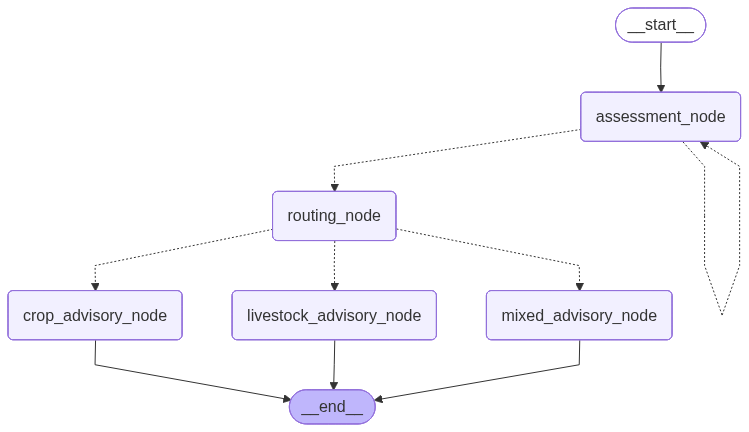


📊 Farm Advisor Graph Structure (Separate Nodes):
  Nodes: __start__, assessment_node, routing_node, livestock_advisory_node, crop_advisory_node, mixed_advisory_node, __end__

🔀 Flow:
  __start__
     ↓
  assessment_node (collects farm info)
     ⟲ (loops until complete)
     ↓
  routing_node (hybrid: keywords + LLM)
     ├─→ livestock_advisory_node (with RAG) → __end__
     ├─→ crop_advisory_node → __end__
     └─→ mixed_advisory_node (with RAG) → __end__

✨ Hybrid routing uses keyword matching first (free, fast)
   Falls back to LLM only when uncertain


In [15]:
# Quick display of the farm advisor graph
from IPython.display import Image, display

try:
    graph_repr = graph.get_graph()
    png_bytes = graph_repr.draw_mermaid_png()
    display(Image(png_bytes))
    
    # Also show the structure
    print("\n📊 Farm Advisor Graph Structure (Separate Nodes):")
    print(f"  Nodes: {', '.join(graph_repr.nodes.keys())}")
    print(f"\n🔀 Flow:")
    print(f"  __start__")
    print(f"     ↓")
    print(f"  assessment_node (collects farm info)")
    print(f"     ⟲ (loops until complete)")
    print(f"     ↓")
    print(f"  routing_node (hybrid: keywords + LLM)")
    print(f"     ├─→ livestock_advisory_node (with RAG) → __end__")
    print(f"     ├─→ crop_advisory_node → __end__")
    print(f"     └─→ mixed_advisory_node (with RAG) → __end__")
    print(f"\n✨ Hybrid routing uses keyword matching first (free, fast)")
    print(f"   Falls back to LLM only when uncertain")
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Make sure the graph is compiled and langgraph is installed.")


---

## 🎯 Architecture Summary: Separate Node Design

### Graph Structure:

```
__start__
   ↓
assessment_node (Q&A loop)
   ↓
routing_node (hybrid routing)
   ├─→ livestock_advisory_node (with RAG) → __end__
   ├─→ crop_advisory_node → __end__
   └─→ mixed_advisory_node (with RAG) → __end__
```

### Key Features:

#### 1. **Hybrid Routing** ⚡
- **Primary**: Keyword matching (50+ terms)
  - Livestock: cattle, cow, sheep, goat, pig, chicken, etc.
  - Crops: corn, wheat, rice, tomato, etc.
- **Fallback**: LLM classification (only when uncertain)
- **Cost**: ~$0 most of the time, ~$0.0001 for LLM fallback

#### 2. **Specialized Advisory Nodes**
- **Livestock Node**: Expert livestock manager with RAG
- **Crop Node**: Agronomist expert (no RAG needed)
- **Mixed Node**: Integrated farming expert with RAG

#### 3. **Benefits**:
- ✅ Clear separation of concerns
- ✅ Easier to maintain and test
- ✅ Specialized prompts for each domain
- ✅ Scalable (easy to add aquaculture, agroforestry, etc.)
- ✅ Cost-optimized routing

### Next Steps:

1. **Test with livestock query**: "I have dairy cattle"
2. **Test with crop query**: "I grow corn and tomatoes"
3. **Test with mixed query**: "I have chickens and grow vegetables"


## Test the Farm Advisory System

This test includes:
- **Recursion limit** (50) to prevent infinite loops
- **Enhanced debugging** to track routing decisions
- **User-driven assessment** that starts with an open question
- **Hybrid routing** (keyword + LLM fallback)
- **Separate advisory nodes** for livestock, crops, and mixed farming

Run this cell to test the complete flow!


In [16]:
# Fixed Test with Recursion Limit and Proper Interrupt Handling
# This test includes proper recursion limits to prevent infinite loops

# Configuration with recursion limit
config = {
    "configurable": {
        "thread_id": "test-farm-fixed-v2"
    },
    "recursion_limit": 50  # Reasonable limit for assessment + routing + advisory
}

# Initial state
initial_state = {
    "history": []  # Start with empty history for first open question
}

print("="*60)
print("STARTING FARM ASSESSMENT (With Recursion Limit)")
print("="*60)
print(f"Config: {config}\n")

from langgraph.types import Command

# Main interaction loop
max_rounds = 20  # Maximum number of question-answer rounds
round_num = 0

try:
    # Start the graph
    events = list(graph.stream(initial_state, config, stream_mode="values"))
    
    while round_num < max_rounds:
        round_num += 1
        print(f"\n[Round {round_num}]")
        
        # Check current state
        current_state = graph.get_state(config)
        
        # If graph is complete (no next nodes), we're done
        if not current_state.next:
            print("\\n" + "="*60)
            print("✓ GRAPH EXECUTION COMPLETE")
            print("="*60)
            
            # Display final results
            final_values = current_state.values
            print("\\n" + "="*80)
            print("FINAL RESULTS")
            print("="*80)
            print(f"\\n📍 Assessment Summary:")
            print(f"   {final_values.get('assessment_summary', 'None')}")
            print(f"\\n📂 Advisory Type: {final_values.get('advisory_type', 'None')}")
            
            if final_values.get('diagnosis'):
                print(f"\\n📋 FULL DIAGNOSIS:")
                print("="*80)
                print(final_values.get('diagnosis', 'None'))
                print("="*80)
            
            if final_values.get('recommendations'):
                print(f"\\n💡 RECOMMENDATIONS:")
                print("="*80)
                for i, rec in enumerate(final_values.get('recommendations', []), 1):
                    print(f"\\n{i}. {rec}")
                print("="*80)
            break
        
        # Check if there's an interrupt (waiting for user input)
        has_interrupt = False
        if current_state.tasks and len(current_state.tasks) > 0:
            task = current_state.tasks[0]
            if task.interrupts and len(task.interrupts) > 0:
                has_interrupt = True
                ui_schema = task.interrupts[0].value
                
                print("\\n" + "="*50)
                print("INTERRUPT: Need user input")
                print(f"Question: {ui_schema.get('question', 'No question')}")
                if ui_schema.get('options'):
                    print("Options:")
                    for i, opt in enumerate(ui_schema['options'], 1):
                        print(f"  {i}. {opt}")
                print("="*50)
                
                # Get user input
                user_response = input("Your response: ")
                if user_response.lower() in ['exit', 'quit', 'q']:
                    print("\\nExiting...")
                    break
                
                print(f"\\nYour response: {user_response}\\n")
                
                # Resume with user response
                events = list(graph.stream(
                    Command(resume=user_response), 
                    config, 
                    stream_mode="values"
                ))
                
                # Continue to next round
                continue
        
        # If no interrupt and graph still has next nodes, something is wrong
        if not has_interrupt and current_state.next:
            print(f"⚠️ Warning: Graph has next nodes but no interrupt detected")
            print(f"   Next nodes: {current_state.next}")
            print(f"   This might indicate an issue with the graph")
            break
    
    if round_num >= max_rounds:
        print(f"\\n⚠️ Reached maximum rounds ({max_rounds}), stopping...")

except Exception as e:
    print(f"\\n❌ Error during execution: {e}")
    import traceback
    traceback.print_exc()
    
    # Show current state for debugging
    try:
        current_state = graph.get_state(config)
        print("\\nCurrent State (for debugging):")
        print(f"  Next nodes: {current_state.next}")
        print(f"  Assessment summary: {current_state.values.get('assessment_summary', 'None')[:100]}...")
        print(f"  Advisory type: {current_state.values.get('advisory_type', 'None')}")
        print(f"  Has tasks: {len(current_state.tasks) if current_state.tasks else 0}")
    except Exception as debug_error:
        print(f"  Could not get debug info: {debug_error}")

print("\\n" + "="*60)
print("TEST COMPLETE")
print("="*60)


STARTING FARM ASSESSMENT (With Recursion Limit)
Config: {'configurable': {'thread_id': 'test-farm-fixed-v2'}, 'recursion_limit': 50}


[DEBUG] Completion check (issue-first approach):
  - question_count: 0 (max: 8)
  - has_issue: False (None)
  - has_crops/livestock: False (None)
  - has_location: False (None)
[DEBUG] Should complete: NO - continuing with questions

[Round 1]
\n==================================================
INTERRUPT: Need user input
Question: Hello there! It's wonderful to have you here. To help me understand how I can best assist you today, could you tell me a bit about what's on your mind regarding your farm? What brings you here for advice?
Options:
  1. Crop disease or pest issues
  2. Livestock health or management concerns
  3. Ideas for improving crop yields or farm productivity
  4. Something else entirely
\nYour response: \n

[DEBUG] Completion check (issue-first approach):
  - question_count: 0 (max: 8)
  - has_issue: False (None)
  - has_crops/livestock

KeyboardInterrupt: Interrupted by user